# Exercises

## Part A: The structure of the Philosopher network

*Exercises*: Structure of the the philosopher network

Last time, we found the most connected philosophers (using degree centrality). Now let's dig in and try to understand more about the philosopher network using more advanced network features. If your network has more than one component, just work on the giant connected component (GCC) in the exercises below (in a directed graph use the weakly connected component).

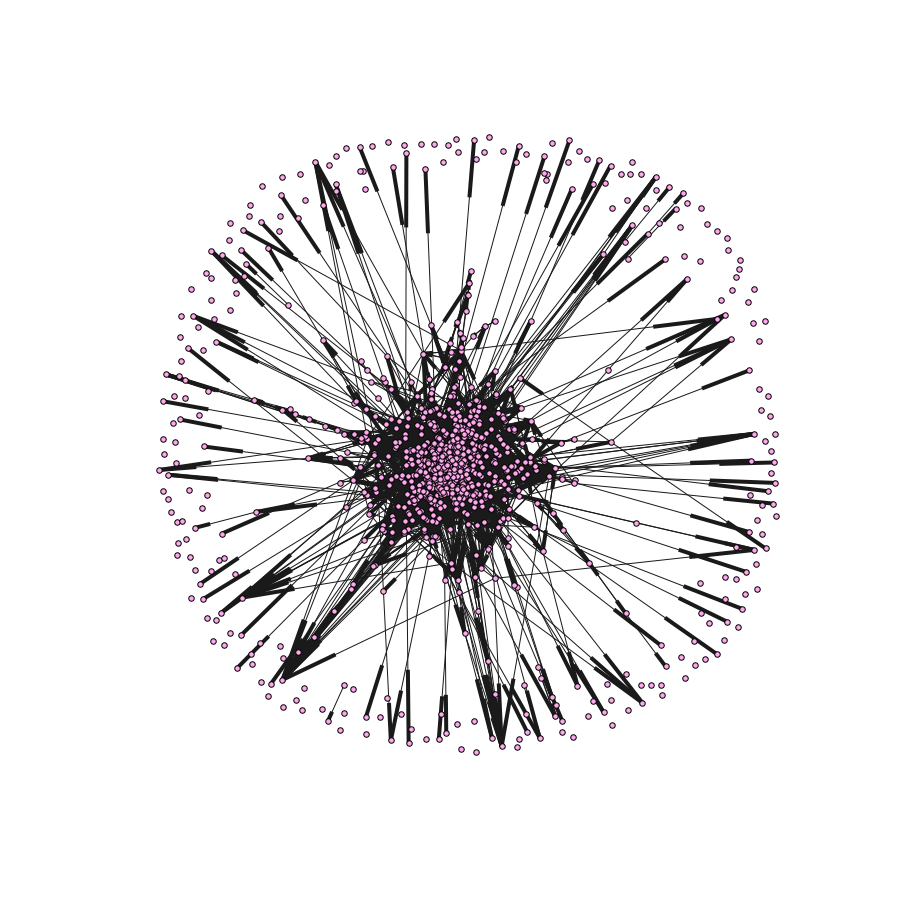

In [1]:
from os import listdir
from os.path import isfile, join
import networkx as nx
import matplotlib.pyplot as plt
import cPickle as pickle
import re
%matplotlib inline 

# First, recreate the graph from last week

def load_philosopher_from_file(file_name):
    with open(file_name, 'rb') as f:
        philosopher_json = pickle.load(f)
        return philosopher_json

def get_list_of_philosophers_files(directory):
    files = [join(directory, f) for f in listdir(directory) if isfile(join(directory, f))]
    return files

# Redefine the regex - we don't need to take into account this time the leading * as we did earlier on 
re_wiki_link = r'\[\[([^\[\]|]+)[^\[\]]*\]\]'

philosophers_dir = './philosophers'

# Create a standard graph
phi_network = nx.DiGraph()

# Get all the files with the philosophers information
philosopher_files = get_list_of_philosophers_files(philosophers_dir)

philosophers_unique = set()
philosophers = []

for philosopher_file in philosopher_files:
    philosopher_wikipage = load_philosopher_from_file(philosopher_file)
    
    philosopher_pages = philosopher_wikipage['query']['pages']
    philosopher_content = philosopher_pages[philosopher_pages.keys()[0]]
    
    # Add node in the network
    philosopher_name = philosopher_content['title']
    phi_network.add_node(philosopher_name)
    
    # Add philosopher to unique list
    philosophers_unique.add(philosopher_name)
    philosophers.append(philosopher_content)
    
for philosopher_content in philosophers:
    # Retrieve the content in the page
    content_in_page = philosopher_content['revisions'][0]['*']
    
    # Find all links in the page
    links_in_page = re.findall(re_wiki_link, content_in_page)
    
    # Find all links in the page that refer to philosophers in our list using set's intersection
    connections = list(philosophers_unique.intersection(set(links_in_page)))
    
    philosopher_name = philosopher_content['title']
    
    # Add the edges to the network 
    connections_to_add = [(philosopher_name, connection) for connection in connections]
    phi_network.add_edges_from(connections_to_add)

# Plot the network     
pos = nx.spring_layout(phi_network)
plt.figure(1,figsize=(12,12))
nx.draw(phi_network, node_size=30, node_color="#FFA8EE", node_shape='o', edge_color='.1', with_labels=False, width=1, pos=pos)
plt.show()

* **Not all of the measures we'll be considering below are defined for directed graphs, thus begin by creating an undirected version of the philosopher graph, that we can use whenever needed. Only use the undirected graph when explicitly stated in the exercise.**

In [2]:
# Make the philosophers network an undirected graph
undirected_phi_network = phi_network.to_undirected()

* **Find the 5 most central philosophers according to betweenness centrality. What role do you imagine philosophers with high wikipedia graph betweenness centrality play in the history of philosophy?**

In [3]:
# Compute the betweenness centrality
phi_between_centrality = nx.betweenness_centrality(undirected_phi_network)

# Sort the dictionary (thus the iteritems) by the value in descending order (thus the "-")
phi_between_centrality_sorted = sorted(phi_between_centrality.iteritems(), key=lambda (name, value): -value)

print "The 5 most central philosophers according to betweenness centrality :\n" 
print phi_between_centrality_sorted[:5]

The 5 most central philosophers according to betweenness centrality :

[(u'Aristotle', 0.08051969440565435), (u'Immanuel Kant', 0.07704721969305633), (u'Bertrand Russell', 0.0662171565693034), (u'Plato', 0.05112539640728451), (u'David Hume', 0.04352885999009065)]


* ** Find the 5 most central philosophers according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details). How is eigenvector centrality difference from degree centrality? Compare your results for eigenvector centrality to the results for betweenness centrality - does the difference make sense when you read the philosopher's wikipedia pages? **

In [4]:
phi_eigen_centrality = nx.eigenvector_centrality(undirected_phi_network)

# Sort the dictionary (thus the iteritems) by the value in descending order (thus the "-")
phi_eigen_centrality_sorted = sorted(phi_eigen_centrality.iteritems(), key=lambda (name, value): -value)

print "Top 5 philosophers by eigenvector centrality : "
print phi_eigen_centrality_sorted[:5]

# The eigenvector_centrality computes the centrality for the in degree
phi_eigen_centrality_in = nx.eigenvector_centrality(phi_network)
# To get the centrality for out degree, we need to reverse the network according to the documentation. 
phi_eigen_centrality_out = nx.eigenvector_centrality(phi_network.reverse())

phi_eigen_centrality_in_sorted = sorted(phi_eigen_centrality_in.iteritems(), key=lambda (name, value): -value)
phi_eigen_centrality_out_sorted = sorted(phi_eigen_centrality_out.iteritems(), key=lambda (name, value): -value)

print "\nTop 5 philosophers by eigenvector centrality in-degree: "
print phi_eigen_centrality_in_sorted[:5]

print "\nTop 5 philosophers by eigenvector centrality out-degree: "
print phi_eigen_centrality_out_sorted[:5]

Top 5 philosophers by eigenvector centrality : 
[(u'Immanuel Kant', 0.26625712739602925), (u'Aristotle', 0.22908873929787757), (u'Bertrand Russell', 0.19064393635422136), (u'Plato', 0.18893071447982393), (u'Georg Wilhelm Friedrich Hegel', 0.18225516413956178)]

Top 5 philosophers by eigenvector centrality in-degree: 
[(u'Immanuel Kant', 0.3198747275571033), (u'Aristotle', 0.27154012653574494), (u'Bertrand Russell', 0.24345793426706938), (u'Plato', 0.22107355844833396), (u'Friedrich Nietzsche', 0.2037818531837984)]

Top 5 philosophers by eigenvector centrality out-degree: 
[(u'Georg Wilhelm Friedrich Hegel', 0.20436710565280286), (u'Martin Heidegger', 0.19148872169125503), (u'Friedrich Nietzsche', 0.18936630647823904), (u'Immanuel Kant', 0.18339749487247126), (u'Michel Foucault', 0.15384727596915646)]


* **Is the undirected version of the graph assortative with respect do degree? (e.g. do high-degree philosophers tend to link to other high-degree philosophers, and low-degree philosophers to other low-degree philosophers?). Provide an interpretation of your answer?**

In [5]:
phi_degree_assortativity = nx.degree_assortativity_coefficient(undirected_phi_network)

print phi_degree_assortativity

-0.0699362906963


*Exercises*: Age and structure in the philosopher network

Age of the philosophers plays a large role. Socrates/Plato and Aristotle are massive influences on philosophy in millennia subsequent to their birth. Now, let us explore how the birth-year of the philosophers plays a role in shaping the network. We've created a file (.json format) which provides the birth year for most of the philosophers. Get it here. In the following, you may use that to get the birth-year for the philosopher. Note: It's possible that the list of names in the list of birth-years is not identical to the set of nodes in your network; thus, for the exercises including age, simply work on the subgraph of nodes for which you have age-info.

In [6]:
import json
# Retrieve the philosophers ages

def load_phi_birthdates(file_name):
    with open(file_name, 'r') as f:
        # Load and parse json content
        content = json.load(f)
        return content

philosophers_birthdates = load_phi_birthdates('philosopher_birth_year.json')

# Sub dictionary of the original json with only the philosophers for who we have an age
philosophers_with_birthdates = {k:philosophers_birthdates[k] for k in philosophers_unique if k in philosophers_birthdates}

# Create a subgraph of the current philosophers graph based on the names of the philosophers for who we have an age 
phi_network_birthdates = phi_network.subgraph(philosophers_with_birthdates.keys())
# Also create the undirected version 
phi_network_birthdates_undirected = phi_network_birthdates.to_undirected()

# Add the birthdate in the graph as an attribute of each node
nx.set_node_attributes(phi_network_birthdates_undirected, 'birthdate', philosophers_with_birthdates)

# See how many philosophers we captured in our subgraph
print "Number of philosophers with ages in our graph : %d" % len(phi_network_birthdates_undirected.nodes())
print "Number of philosophers in the original fine : %d" % len(philosophers_birthdates)

Number of philosophers with ages in our graph : 343
Number of philosophers in the original fine : 1563


*We have much less philosophers in our graph than in the birthdates file but we can still carry on our analysis as this is still an important number*

* **Create a histogram of the number of philosophers born in every century, starting 500 BC. Describe the plot. Does philosophy seem to have developed at a steady pace - or in a more bursty manner? Are we living in a golden age of philosophy right now? (Use the data & common sense to present an argument for your answer).**

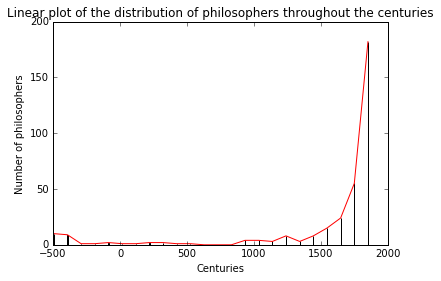

In [7]:
import numpy as np

# Filter out any philosophers that was born before 500 BC
birthdates = [birthdate for birthdate in philosophers_with_birthdates.values() if birthdate >= -500]

# Start at century 500 BC as requested
min_century = -500
max_century = max(birthdates)

# Compute the bins for our degree distribution, diving by 100 as we have a step of one century
bins = (max_century - min_century) / 100

centuries_hist, centuries_bin = np.histogram(birthdates, bins=bins)

plt.plot(centuries_bin[:-1], centuries_hist, 'r')
plt.bar(centuries_bin[:-1], centuries_hist, color='b')
plt.xlabel('Centuries')
plt.ylabel('Number of philosophers')
plt.title('Linear plot of the distribution of philosophers throughout the centuries')
plt.show()

Based on the plot, we can see that the number of philosophers we have in our data is particularly low between 500 BC and 1500 AD and then litteraly bursts until our century from around 20 philosophers to slightly more than 180. 

We can say that we are living in an age where there a lot of philosophers, but as for the Golden Age, it all depends on the point of view. Will the work of the philosophers' of the last century be as influential as the work from the past centuries ? 

However, we must be careful that those are birth dates, and typically a philosopher born at the end of a century will not be counted into the century in which he actually was a proper philosopher. 

* ** Is the undirected version of the graph assortative with respect to age? Once again, provide an interpretation of your answer.**

In [8]:
phil_age_assortativity = nx.attribute_assortativity_coefficient(phi_network_birthdates_undirected,'birthdate')

print phil_age_assortativity

-0.00244172415775


The undirected version of the graph is ..

* ** A reasonable hypothesis is that old philosophers are more famous. Create a scatter-plot of age versus in-degree. Do you see a correlation between the two? Justify your answer (for example by calculating the correlation coefficient.)** 

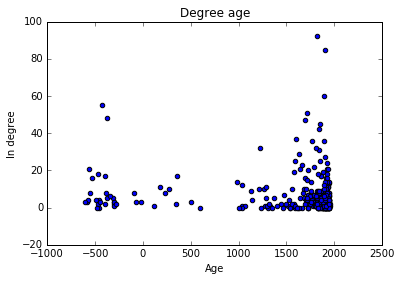

In [9]:
ages = philosophers_with_birthdates.values()
in_degrees = [phi_network_birthdates.in_degree(node) for node in phi_network_birthdates]

plt.scatter(ages, in_degrees)
plt.xlabel('Age')
plt.ylabel('In degree')
plt.title('Degree age')
plt.show()

We can see a correlation between the two as .. 

If we look at the following correlation coefficient for the ages and in-degrees, we see that we have a value of -0.055, indicating that there are no linear correlation between the two. 

In [10]:
correlation_coeff = np.corrcoef(ages, in_degrees)
print correlation_coeff[0,1]

-0.0554813392735


## Part B: The branches of philosophy. Are they communities?

*Exercises*: We will use the concept of modularity to explore how community-like the six branches of philosophy are.

* ** Explain the concept of modularity in your own words. **

Modularity is .. 

** Now we will calculate the modularity of the branches reported by the Wikipedia editors. But we need to do a bit of work to make this happen. **
** Firstly, modularity does not work when the communities are overlapping. Thus, we need to do something about the philosophers that are part of multiple branches. We will handle it by creating a set of six new branches, where we take all of the philosophers that belong to more than one branch and assign them to the branch that they have the most connections to. The procedure is the following: **

*    ** Start with creating six new branches (e.g. represented as sets in Python) containing all of the philosopher that can be unambiguously assigned to a branch. **

In [11]:
import io
# More advanced regex that captures links with whitespaces and doesn't require any manual pre-processing of the file
re_wiki_link = r'\*.*?\[\[([^\[\]|]+)[^\[\]]*\]\]' 

def load_philosophers_from_file(file_name):
    f = io.open(file_name, 'r', encoding='utf-8')

    # Find all matches
    philosophers_matches = re.findall(re_wiki_link, f.read())
    return philosophers_matches

def create_philosophers_dict():
    philosophers_branches = {}
    
    aestheticians_matches = load_philosophers_from_file('philosophers_aestheticians.txt')
    epistemologists_matches = load_philosophers_from_file('philosophers_epistemologists.txt')
    ethicists_matches = load_philosophers_from_file('philosophers_ethicists.txt')
    logicians_matches = load_philosophers_from_file('philosophers_logicians.txt')
    metaphysicians_matches = load_philosophers_from_file('philosophers_metaphysicians.txt')
    sociopoliticians_matches = load_philosophers_from_file('philosophers_sociopolitical.txt')
    
    # Check if philosopher is in branch_name, and add the branch to his list of branches if so
    def if_philosopher_in_branch(philosopher, branch_name, branch_matches):
        if philosopher in branch_matches:
            if philosopher in philosophers_branches:
                philosophers_branches[philosopher].add(branch_name)
            else:
                # If the philosopher is not yet in the dictionary, create a new set with the current branch
                philosophers_branches[philosopher] = {branch_name} 
    
    # Helper method to check in each branch
    def check_if_philosopher_in_one_branch(philosopher):
        if_philosopher_in_branch(philosopher, 'aestheticians', aestheticians_matches)
        if_philosopher_in_branch(philosopher, 'epistemologists', epistemologists_matches)
        if_philosopher_in_branch(philosopher, 'ethicists', ethicists_matches)
        if_philosopher_in_branch(philosopher, 'logicians', logicians_matches)
        if_philosopher_in_branch(philosopher, 'metaphysicians', metaphysicians_matches)
        if_philosopher_in_branch(philosopher, 'sociopoliticians', sociopoliticians_matches)
    
    # For each philosopher, check in which branch they belong to
    for philosopher in philosophers_unique:
        check_if_philosopher_in_one_branch(philosopher)
        
    return philosophers_branches

In [12]:
philosophers_branches = create_philosophers_dict()

branches_unambigous = {}
philosophers_ambigous = {}

for philosopher, branches in philosophers_branches.iteritems():
    # If the philosopher only belongs to one branch, we can add him to the unambigous branches
    if len(branches) == 1:
        # Get branch from set (first item)
        current_branch = next(iter(branches))
        # If branch already in our dictionary, add him to the current set
        if current_branch in branches_unambigous:
            branches_unambigous[current_branch].add(philosopher)
        else:
            # If the branch is not yet in the dictionary, create a new entry with a set containing the philosopher 
            branches_unambigous[current_branch] = {philosopher}
    # If we have more than one branch, add the philosopher to our list of ambigous philosophers
    elif len(branches) > 1:
        philosophers_ambigous[philosopher] = {}

print branches_unambigous.keys()

['sociopoliticians', 'aestheticians', 'logicians', 'epistemologists', 'metaphysicians', 'ethicists']


* **Then, take the list of all nodes that are part of more than one branch. For each member i of this list, how many links i has to each of his/her branches. **

In [13]:
def explore_connections(philosopher, links, philosophers_ambigous):
    # Go through each link 
    for link in links:
        linked_philosopher = link[1]
        # If the linked philosopher is also in our ambigous list, post pone it's analysis to later on
        if linked_philosopher in philosophers_ambigous:
            continue
        else:
            for branch, philosophers in branches_unambigous.iteritems():
                # If the philosopher is in the list of the philosophers of the current branch
                if linked_philosopher in philosophers:
                    # Increment the count for this branch if we already had a value for it 
                    if branch in philosophers_ambigous[philosopher]:
                        philosophers_ambigous[philosopher][branch] += 1
                    # Else initialize it to 1 
                    else:
                        philosophers_ambigous[philosopher][branch] = 1
                    # We can safely break from this loop as we have found the branch in which the linked philosopher was
                    break

In [14]:
# For each philosopher in the ambigous list, explore its neighbors 
for philosopher, branches in philosophers_ambigous.iteritems():
    # Get links
    links = undirected_phi_network.edges(philosopher) 
    
    # If there are no links, we'll assume that we add the philosopher to the first of his branches 
    if len(links) == 0:
        arbitrary_branch = next(iter(philosophers_branches[philosopher]))
        philosophers_ambigous[philosopher][arbitrary_branch] = 1
    else:
        # Explore all of the connections of the philosopher
        explore_connections(philosopher, links, philosophers_ambigous)
                
print philosophers_ambigous

{u'Christian Wolff (philosopher)': {'aestheticians': 1, 'sociopoliticians': 1, 'logicians': 1, 'ethicists': 1}, u'Martin Heidegger': {'sociopoliticians': 16, 'aestheticians': 4, 'logicians': 1, 'epistemologists': 2, 'metaphysicians': 9, 'ethicists': 8}, u'Thomas Hill Green': {'logicians': 1, 'aestheticians': 1, 'epistemologists': 1}, u'Jeremy Bentham': {'sociopoliticians': 5, 'logicians': 1, 'metaphysicians': 1, 'ethicists': 10}, u'Martha Nussbaum': {'sociopoliticians': 2, 'aestheticians': 1, 'ethicists': 4}, u'Joxe Azurmendi': {'sociopoliticians': 2, 'aestheticians': 1}, u'John Hospers': {}, u'Walter Terence Stace': {'sociopoliticians': 1, 'aestheticians': 1, 'metaphysicians': 1, 'ethicists': 1}, u'Jessica Wilson': {'epistemologists': 1}, u'Baruch Spinoza': {'epistemologists': 2, 'sociopoliticians': 9, 'aestheticians': 7, 'metaphysicians': 6, 'ethicists': 6}, u'Francis Hutcheson (philosopher)': {'logicians': 1, 'sociopoliticians': 2, 'aestheticians': 3, 'metaphysicians': 1, 'ethicists

* ** Add i to to the branch that it has most connections to. **

In [15]:
# TODO Which branch to take when there are multiple branches possible (all the same count)
def add_philosopher_to_max_branch(philosopher, branches):
    max_branch = ""
    max_count = 0
    # Go through each branch and find the branch where the count is the highest
    for branch, count in branches.iteritems():
        if count >= max_count:
            max_count = count
            max_branch = branch
    if max_count != 0:
        # Add the philosopher to the branch where he has the most connections 
        branches_unambigous[max_branch].add(philosopher)

# For each philosopher, add the philosopher to his max branch 
for philosopher, branches in philosophers_ambigous.iteritems():
    add_philosopher_to_max_branch(philosopher, branches)

We now need to take care of the philosophers we couldn't process earlier on : those that had connections to ambigous philosophers, and thus couldn't be analyzed as such. 

In [16]:
# Filter out the philosophers that have no branches (those that couldn't be processed)
philosophers_ambigous_remaining = {philosopher: branches 
                                   for philosopher, branches in  philosophers_ambigous.iteritems() 
                                   if len(branches) == 0}

# For each of them, repeat the same process as before, by exploring their connections 
for philosopher, branches in philosophers_ambigous_remaining.iteritems():
        print "Current philosopher: %s" % philosopher
        # Get links
        links = undirected_phi_network.edges(philosopher)
        # Explore the connections of the remaining philosophers 
        explore_connections(philosopher, links, philosophers_ambigous_remaining)

Current philosopher: Berit Brogaard
Current philosopher: Trenton Merricks
Current philosopher: Catherine Elgin
Current philosopher: John Hospers
Current philosopher: Sun Yat-sen
Current philosopher: Robert S. Hartman


In [17]:
print philosophers_ambigous_remaining

{u'Berit Brogaard': {'logicians': 2}, u'Trenton Merricks': {'metaphysicians': 1}, u'Catherine Elgin': {'logicians': 1}, u'John Hospers': {'sociopoliticians': 1}, u'Sun Yat-sen': {'sociopoliticians': 1}, u'Robert S. Hartman': {'ethicists': 1}}


In [18]:
# For each philosopher that was remaining in our list, add the philosopher to his max branch 
for philosopher, branches in philosophers_ambigous_remaining.iteritems():
    add_philosopher_to_max_branch(philosopher, branches)

* **Now that we have a new set of non-overlapping branches, we can calculate the modularity, described in the Network Science book, section 9.4). Use equation 9.12 in the book to calculate the modularity M of the branches-partitioning. ** 

In [19]:
branches_partitioning = {}
for branch, philosophers in branches_unambigous.iteritems():
    branches_partitioning[branch] = phi_network.subgraph(philosophers)

In [20]:
from __future__ import division

def compute_modularity(G, communities):
    # Number of communities
    n_c = len(communities)
    # Number of links
    L = len(G.edges())
    
    modularity = 0
    for community_name, subgraph in communities.iteritems():
        # Total degree of nodes
        k_c = sum(nx.degree(subgraph).values())
        # Total number of links
        L_c = len(subgraph.edges())
        
        modularity += (L_c / L) - (k_c / (2*L))**2
    
    return modularity

In [21]:
m = compute_modularity(undirected_phi_network, branches_partitioning)
print m

0.517433797586


* **Comment on the value of M. Are the branches good communities? (We will explore this question in depth below.)**

We can see that the value of M is around 0.5, which indicates a good partitioning and thus good communities. 

## Part C: Community detection in the full philosopher network.

*Exercises*: As a final exercise, we will now run community detection on the full philosopher network. 

* ** Use the Python Louvain-algorithm implementation to find communities in the full philosopher network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the branches as communities? What does this comparison reveal about the branches?**

In [22]:
import community

partition = community.best_partition(undirected_phi_network)
louvain_modularity = community.modularity(partition, undirected_phi_network)

print louvain_modularity

0.456286403688


We get a value of 0.46 with this implementation, which is pretty close to what we found by hand. It is slightly lower however. 

We can say that this modularity is pretty high, indicating that we have good partitions in our network. 

* ** Compare the communities found by your algorithm with the branches of philosophy by creating a matrix D with dimension (B times C), where B is the number of branches and C is the number of communities. We set entry D(i,j) to be the number of nodes that branch i has in common with community j. The matrix D is what we call a confusion matrix. Use the confusion matrix to explain how well the communities you've detected correspond to the labeled branches of philosophy. **

In [23]:
communities = {}

# Create a dictionary of all communities and their associated philosophers for easier processing when dealing with the confusion matrix
for philosopher, community_index in partition.iteritems():
    if community_index in communities:
        communities[community_index].add(philosopher)
    else:
        communities[community_index] = {philosopher}
    
nb_communities = len(communities)
# Initialize the confusion matrix with the branches as rows and the communities as columns
confusion_matrix = np.zeros(shape=(len(branches_unambigous), nb_communities))
print "Confusion matrix shape :" 
print confusion_matrix.shape

# Go through each branch, and through each community, and check whether we have some philosophers in common
for i, (branch, philosophers) in enumerate(branches_unambigous.iteritems()):
    for community_index, philosophers_community in communities.iteritems():
        # Compute the length of the intersection between the philosophers in the current branch and the ones in the current community
        nb_common = len(philosophers.intersection(philosophers_community))
        # Add the result to the D(i,j) entry
        confusion_matrix[i, community_index] = nb_common

print confusion_matrix

Confusion matrix shape :
(6, 200)
[[ 20.  91.   0. ...,   0.   1.   0.]
 [ 14.  22.   0. ...,   0.   0.   0.]
 [ 44.   0.   1. ...,   0.   0.   0.]
 [  7.   4.   0. ...,   0.   0.   0.]
 [ 20.   9.   0. ...,   0.   0.   0.]
 [ 45.  25.   0. ...,   1.   0.   1.]]


The confusion matrix enables us to see whether our partitioning into branch matches the partitioning into communities by the algorithm. As we can see, the values on each row are more or less distributed into a few communities, indicating that there might a relation between the branch and a subset of the communities. 

However, it is evident that having 6 branches versus 200 communities will not be able to match perfectly. 

## Part D: Properties of individual branches of philosophy

This part is optional! But I recommend that you work through it anyway - it is probably the exercise that will teach you the most about philosophy.

*Exercises*: Understanding the branches of philosophy. You already know a lot about network analysis, so in this assignment I'm providing fewer details on what I want you to do: Figuring out what things to calculate in order to provide an awesome quantitative answer to my questions is part of the assignment. That way you can show that you're able to use the skills you've acquired up till now.

* **Perform an centrality analysis of each of the six branches of philosophy knowing what you've just learned about centrality in complex networks. Use your analysis to reveal the identity of the most important figures in each branch of philosophy. **